# Clothes Article Clssification

This Notebook presents a solution for a fine-grained clothing classification problem. The solution implemented using Keras library. The model trained on a Windows machine with an RTX 3090 GPU.



In [2]:
#!pip3 install keras_flops

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [24]:
from keras.callbacks import ModelCheckpoint
from keras.datasets import fashion_mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
#from keras_flops import get_flops

## Data
Fashion MNIST dataset, an alternative to MNIST. This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST.

### Analysis of Data

In [5]:
dataset = fashion_mnist
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
((x_train, y_train),(x_test, y_test)) = dataset.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size = 0.1, random_state = 12345)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

4431872/4422102 [==============================] - 0s 0us/step
(54000, 28, 28) (54000,) (10000, 28, 28) (10000,) (6000, 28, 28) (6000,)


*please note that MNIST is grayscale if drawn as RGB, the color will be distorted*

Text(0.5, 1.0, '7')

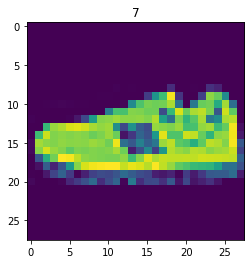

In [7]:
plt.imshow(x_train[20])
plt.title(y_train[20])

Showing classes and images as a demo

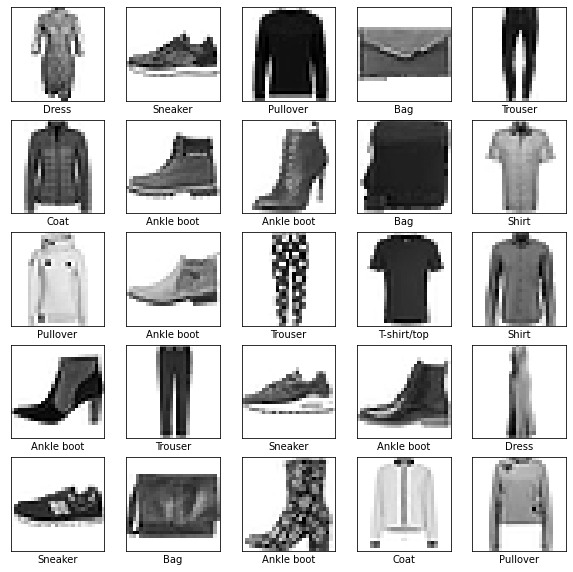

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

Checking if dataset is balanced or not

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'image category index')

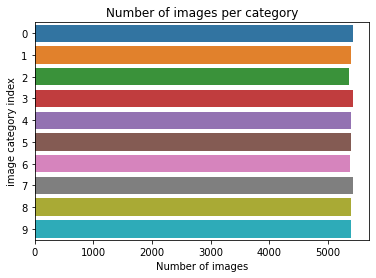

In [9]:
sns.barplot(np.bincount(y_train),np.unique(y_train),orient='h')
plt.title('Number of images per category')
plt.xlabel('Number of images')
plt.ylabel('image category index')

### Preprocessing & Feature Engineering

In [10]:
# Adding and extra dimension
x_train = np.expand_dims(x_train,-1)
x_test = np.expand_dims(x_test,-1)
x_val = np.expand_dims(x_val,-1)

# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0

# one-hot encoding the labels
y_test = np_utils.to_categorical(y_test)
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(54000, 28, 28, 1) (54000, 10) (10000, 28, 28, 1) (10000, 10) (6000, 28, 28, 1) (6000, 10)


## Model

In [11]:
# Here we set the epochs for and batch size for the model and the training process
EPOCHS = 50
BATCH_SIZE= 64

### Model Defintion

This is a simple CNN that yields acceptable results. If I had more time, I would experiment more with resnets as the input images are small in size and resnets will give me a deeper network. Resnet34 is the go to example in this case

In [12]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size=(3,3), padding = 'same', input_shape = (28,28,1)))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 32, kernel_size=(3,3), padding = 'same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding = 'same',activation = 'relu'))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding = 'same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))


model.build((BATCH_SIZE,28,28,1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        3

### Model Compilation

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

### Training

Using Keras' ModelCheckpoint to save the model as an HDF5 file for future use. This saved model will include the specified architecture and the weights that the model has learned over the training data. We could then load this model using load_model. By specifying save_best_only we only save the model at its best-performing epoch.

In [14]:
filepath="mlp2-weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(x_train,
                    y_train,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    validation_data = (x_val, y_val), 
                    callbacks = [checkpoint])
                    

Epoch 1/50
844/844 [==============================] - 50s 7ms/step - loss: 0.8611 - accuracy: 0.6755 - val_loss: 0.3391 - val_accuracy: 0.8828

Epoch 00001: val_accuracy improved from -inf to 0.88283, saving model to mlp2-weights.01-0.34.hdf5
Epoch 2/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3751 - accuracy: 0.8655 - val_loss: 0.2908 - val_accuracy: 0.8968

Epoch 00002: val_accuracy improved from 0.88283 to 0.89683, saving model to mlp2-weights.02-0.29.hdf5
Epoch 3/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3150 - accuracy: 0.8871 - val_loss: 0.2445 - val_accuracy: 0.9165

Epoch 00003: val_accuracy improved from 0.89683 to 0.91650, saving model to mlp2-weights.03-0.24.hdf5
Epoch 4/50
844/844 [==============================] - 5s 6ms/step - loss: 0.2867 - accuracy: 0.8958 - val_loss: 0.2302 - val_accuracy: 0.9190

Epoch 00004: val_accuracy improved from 0.91650 to 0.91900, saving model to mlp2-weights.04-0.23.hdf5
Epoch 5/50
844/844 [==

### Plot epoch accuracy


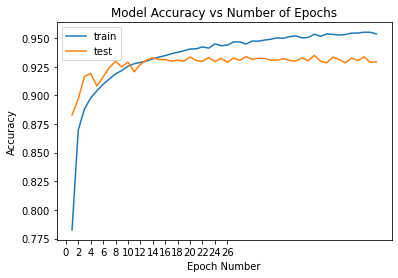

In [15]:
plt.plot(range(1,1+len(history.history['accuracy'])), history.history['accuracy'])
plt.plot(range(1,1+len(history.history['val_accuracy'])), history.history['val_accuracy'])
plt.title('Model Accuracy vs Number of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Number')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

In [16]:
best_score = max(history.history['val_accuracy'])
best_epoch = np.array(history.history['val_accuracy']).argmax()+1
print('Best test accuracy was %f at epoch %i' % (best_score, best_epoch))

Best test accuracy was 0.934833 at epoch 40


### Plot epoch loss


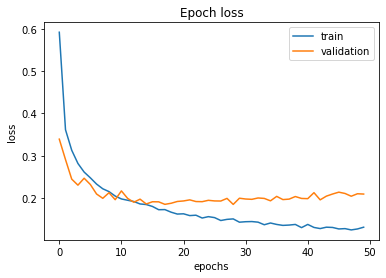

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epoch loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'validation']);

## Evaluation

### Apply & Compare Predictions

In [18]:
y_pred = model.predict(x_test)
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2475 - accuracy: 0.9206


[0.2474953681230545, 0.9205999970436096]

### Confusion Matrix

In [19]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

In [27]:
print('precesion: ', precision_score(y_test, y_pred, average='micro'))
print('recall: ', recall_score(y_test, y_pred, average='micro'))


precesion:  0.9206
recall:  0.9206


In [21]:
matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_names, columns=class_names)
matrix.index.name = 'Predicted'
matrix.columns.name = 'Actual'
matrix

Actual,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
Predicted,,,,,,,,,,
T-shirt/top,886,1,18,12,2,0,76,0,5,0
Trouser,1,992,0,5,0,0,1,0,1,0
Pullover,19,1,911,8,23,0,38,0,0,0
Dress,13,4,8,931,13,0,30,0,1,0
Coat,1,2,84,22,830,0,61,0,0,0
Sandal,0,0,0,0,0,975,0,19,0,6
Shirt,109,4,63,27,42,0,747,0,8,0
Sneaker,0,0,0,0,0,2,0,982,0,16
Bag,1,1,0,3,1,1,0,3,990,0


### Speed

The most expensive layers are the First and second denses, followed by the last concolutional layer

This is an easy way to calcualte flops and macs. But to make sure it works on google colab, I calulated it locally and added the results below. 

*to run it yourself, change keras `from keras.models import Sequential` to `from tensorflow.keras.models import Sequential`*



In [22]:
# FLOPS = 37636028 
# MACs = 18818014.0

# flops = get_flops(model, batch_size=1)
# macs = 0.5 * flops
# print(flops, macs)


## Conclusions

Given the above information here are the pros, cons and things to improve in the model

### Pros

1. effiecient model. has small memory foot print and fast runtime
2. presicion and recall are high yield a near-optimal model

### CONS
1. dataset is too simple which will make the model perform badly when faced with real-life scenarios and images
2. model saturated at ~6th epoch which means the model needs to be more complex in general as well


### Improvements
1. Using Resnets (or skip-connection based model) which will allow us to create deeper networks. This in turn will allow to fit the realistic analysis of clothing articles classification as it is quite diverse

2. try to run on realistic clothes article images to get real sense of performance